In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def horizontal_projection(image):
  """
  Calculates the horizontal projection profile of a binary image.

  Args:
      image: A binary image (grayscale image with 0 for background and 255 for foreground).

  Returns:
      A list representing the horizontal projection profile (number of foreground pixels in each row).
  """
  projection = np.sum(image, axis=1)  # Sum pixels across each row
  return projection.tolist()

def find_peak_values(projection, min_peak_height=5):
  """
  Finds peak values (local maxima) in a 1D list representing a projection profile.

  Args:
      projection: A list representing the horizontal projection profile.
      min_peak_height: Minimum height threshold for considering a peak (optional).

  Returns:
      A list of peak value indices in the projection profile.
  """
  # peaks = []
  # for i in range(1, len(projection)-1):
  #   if projection[i] > projection[i-1] and projection[i] > projection[i+1] and projection[i] >= min_peak_height:
  #     peaks.append(i)
  # return peaks
  
  # peaks = []
  # for i in range(1, len(projection)-1):
  #   if projection[i] > projection[i-1] and projection[i] > projection[i+1] and projection[i] >= min_peak_height:
  #     peaks.append(i)
  # return peaks



def detect_baselines(image):
  """
  Detects multiple baseline indices in a binary line image using horizontal projection.

  Args:
      image: A binary image representing a line of text.

  Returns:
      A list of baseline indices (row indices) in the image and the projection profile.
  """
  # Optional thinning (uncomment if needed)
  # thinned_image = cv2.ximgproc.thinning(image.copy(), thinningType=cv2.ximgproc.THINNING_SAUF)

  # Horizontal projection
  projection = horizontal_projection(image)

  # Optional smoothing (uncomment if needed)
  # smoothed_projection = cv2.GaussianBlur(np.array([projection]), (5, 1), 0)[:, 0]

  # Find peak values (potential baseline locations)
  peaks = find_peak_values(projection)

  # Consider potential filtering/merging of close peaks (optional)

  return peaks, projection

def draw_baselines(image, baseline_indices):
  """
  Draws multiple baselines on the input image.

  Args:
      image: The binary image.
      baseline_indices: A list of row indices for the detected baselines.

  Returns:
      The image with all baselines drawn.
  """
  image_copy = image.copy()
  colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # Define different colors for multiple baselines (optional)
  for i, baseline_index in enumerate(baseline_indices):
    cv2.line(image_copy, (0, baseline_index), (image.shape[1], baseline_index), colors[i % len(colors)], 2)  # Draw lines with color cycling
  return image_copy


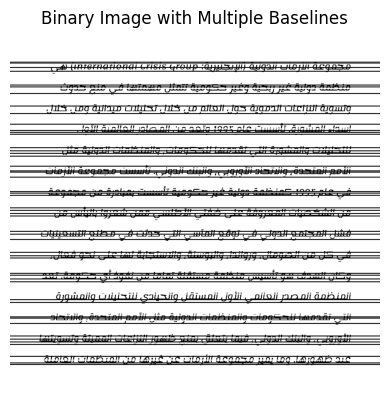

baseline_indices: [99, 103, 105, 116, 128, 132, 172, 178, 183, 199, 239, 257, 263, 297, 312, 317, 323, 326, 329, 372, 378, 382, 390, 396, 399, 431, 439, 446, 450, 462, 466, 512, 515, 517, 524, 533, 564, 572, 579, 582, 590, 599, 639, 648, 657, 665, 706, 712, 717, 724, 733, 773, 779, 782, 791, 800, 839, 857, 866, 906, 912, 916, 924, 933, 973, 979, 983, 992, 996, 1000, 1038, 1050, 1059, 1064]


In [3]:
def find_max_transitions(image, baseline_indices):
    max_transitions = 0
    max_transitions_indices = []  # Store all indices with maximum transitions
    
    for baseline_index in baseline_indices:
        i = baseline_index
        height = len(image)
        while i < height:
            current_transitions = 0
            flag = False  # Flag to track if we are counting transitions
            j = 0
            width = len(image[0])
            
            while j < width:
                if image[i][j] == 1 and not flag:
                    current_transitions += 1
                    flag = True
                elif image[i][j] != 1 and flag:
                    flag = False
                j += 1
                
            if current_transitions > max_transitions:
                max_transitions = current_transitions
                max_transitions_indices = [i]
            elif current_transitions == max_transitions:
                max_transitions_indices.append(i)
            
            i += 1
    
    return max_transitions_indices



# Example usage (replace 'path/to/your/image.png' with your actual image path)
line_image = cv2.imread('fonts-dataset/Lemonada/784.jpeg', cv2.IMREAD_GRAYSCALE)
thresh, binary_image = cv2.threshold(line_image, 127, 255, cv2.THRESH_BINARY)  # Binarize image

# Detect multiple baselines
baseline_indices, projection = detect_baselines(binary_image)

# Draw baselines on image
image_with_baselines = draw_baselines(binary_image, baseline_indices)

# max_transitions_indices = find_max_transitions(binary_image, baseline_indices)

# Display the image with multiple baselines (consider using subplots for projection)
plt.imshow(image_with_baselines, cmap='gray')
plt.title('Binary Image with Multiple Baselines')
plt.axis('off')
plt.show()

print("baseline_indices:", baseline_indices)



In [ ]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode

image = rgb2gray(imread("fonts-dataset/Lemonada/900.jpeg"))

edges = canny(image)
# Classic straight-line Hough transform
tested_angles = np.deg2rad(np.arange(0.1, 180.0))
h, theta, d = hough_line(edges, theta=tested_angles)

print(image.shape)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

print(image.shape[1])
print(origin)

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    print(y0, y1)
    
ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')




In [13]:
import cv2
import os

# Define folder path
folder_path = "fonts-dataset/Lemonada"

# Loop through images in the folder
for filename in os.listdir(folder_path):
  # Check if it's an image file
  if filename.lower().endswith((".jpg", ".jpeg", ".png")):
    # Read the image
    img = cv2.imread(os.path.join(folder_path, filename))
    
    # Check if image read successfully
    if img is not None:
      # Get image shape (height, width) - OpenCV uses (H, W) order
      height, width, channels = img.shape
      # Print the shape
      print(f"{filename}: {width} x {height} (channels: {channels})")



0.jpeg: 1181 x 1181 (channels: 3)
1.jpeg: 1181 x 1181 (channels: 3)
10.jpeg: 1181 x 1181 (channels: 3)
100.jpeg: 1181 x 1181 (channels: 3)
101.jpeg: 1181 x 1181 (channels: 3)
102.jpeg: 1181 x 1181 (channels: 3)
103.jpeg: 1181 x 1181 (channels: 3)
104.jpeg: 1181 x 1181 (channels: 3)
105.jpeg: 1181 x 1181 (channels: 3)
106.jpeg: 1181 x 1181 (channels: 3)
107.jpeg: 1181 x 1181 (channels: 3)
108.jpeg: 1181 x 1181 (channels: 3)
109.jpeg: 1181 x 1181 (channels: 3)
11.jpeg: 1181 x 1181 (channels: 3)
110.jpeg: 1181 x 1181 (channels: 3)
111.jpeg: 1181 x 1181 (channels: 3)
112.jpeg: 1181 x 1181 (channels: 3)
113.jpeg: 1181 x 1181 (channels: 3)
114.jpeg: 1181 x 1181 (channels: 3)
115.jpeg: 1181 x 1181 (channels: 3)
116.jpeg: 1181 x 1181 (channels: 3)
117.jpeg: 1181 x 1181 (channels: 3)
118.jpeg: 1181 x 1181 (channels: 3)
119.jpeg: 1181 x 1181 (channels: 3)
12.jpeg: 1181 x 1181 (channels: 3)
120.jpeg: 1181 x 1181 (channels: 3)
121.jpeg: 1181 x 1181 (channels: 3)
122.jpeg: 1181 x 1181 (channels: 3)